# Dynamic Models for Computational Social Sciences

**Project: Delving into cryptocurrency and stock market dynamics - an application of dynamic factor models**

**By: Luis Ortega**

In this Jupyter Notebook, I carry out an explorative exercise on dynamic factors present in the main cryptocurrency pairs (ADA, BNB, BTC, ETH, XRP) and stock market indexes (SPY 500, DOW JONES, NASDAQ). The data comes from the Yahoo Finance API, is taken with weekly frequency, and is de-meaned and standarized. I estimate two dynamic factor models, one for the cryptocurrency pairs taking as base the work carried out by Figá-Talamanca et al (2021) with some annotations, and another one for the stock market indexes on a more practical approach. Then, we carry out an additional layer of analysis to evaluate wether the dynamic factors of each asset class exhibit a particular relationship in a very simple linear regression framework. The Jupiter Notebook is structured as follows: (1) Data Processing, (2) Dynamic Factors Models and application, and (3) Conclusions and further work.

In [1]:
# pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
import matplotlib.pyplot as plt

%matplotlib inline

***Section 1: Data processing***

In this section we cover the following:
- Creating the set of tickers relevant for the analysis.
- Downloading the raw data with Yahoo Finance API.
- Choosing a frequency to carry out the analysis.
- Dealing with time series lenght and missing values.

In [3]:
# Defining relevant tickers to carry out the analysis

# Cryptocurrency pairs tickers
crypto_tickers = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "ADA-USD"]

# Stock indexes ticker
smi_ticker = ["^GSPC", "^DJI", "^IXIC"]

all_tickers = (
    crypto_tickers + smi_ticker
)


In [4]:
# Downloading the raw data with yf
rawdata = yf.download(
    tickers=all_tickers,
    start="2013-01-01",
    end="2022-05-15",
    interval="1wk"
)

[*********************100%***********************]  9 of 9 completed


In [5]:
# We carry out the analysis with a weekly frequency (can be modified if needed)
data = rawdata["Adj Close"].resample("1W").first()

In [6]:
# We evaluate the lenght of the time series and, for homogeneity's sake, drop any NA observations

# Lenght of the time series:
#data.isna().sum()
# We drop Solana and consider Cardano as more history is available
data = data.drop(columns = 'SOL-USD')

# Dealing with NA's
data = data.dropna()

In [7]:
# Transform the prices to returns (weekly)
data['dln_ADA'] = (np.log(data['ADA-USD'])).diff() * 100
data['dln_BNB'] = (np.log(data['BNB-USD'])).diff() * 100
data['dln_BTC'] = (np.log(data['BTC-USD'])).diff() * 100
data['dln_ETH'] = (np.log(data['ETH-USD'])).diff() * 100
data['dln_XRP'] = (np.log(data['XRP-USD'])).diff() * 100

data['dln_SPX'] = (np.log(data['^GSPC'])).diff() * 100
data['dln_DOWJ'] = (np.log(data['^DJI'])).diff() * 100
data['dln_NASD'] = (np.log(data['^IXIC'])).diff() * 100

# Standardize the returns
data['std_ADA'] = (data['dln_ADA'] - data['dln_ADA'].mean()) / data['dln_ADA'].std()
data['std_BNB'] = (data['dln_BNB'] - data['dln_BNB'].mean()) / data['dln_BNB'].std()
data['std_BTC'] = (data['dln_BTC'] - data['dln_BTC'].mean()) / data['dln_BTC'].std()
data['std_ETH'] = (data['dln_ETH'] - data['dln_ETH'].mean()) / data['dln_ETH'].std()
data['std_XRP'] = (data['dln_XRP'] - data['dln_XRP'].mean()) / data['dln_XRP'].std()

data['std_SPX'] = (data['dln_SPX'] - data['dln_SPX'].mean()) / data['dln_SPX'].std()
data['std_DOWJ'] = (data['dln_DOWJ'] - data['dln_DOWJ'].mean()) / data['dln_DOWJ'].std()
data['std_NASD'] = (data['dln_NASD'] - data['dln_NASD'].mean()) / data['dln_NASD'].std()


# I drop the last observation to homogenize the data observations
data = data.iloc[1:, :]

In [8]:
data

,ADA-USD,BNB-USD,BTC-USD,ETH-USD,XRP-USD,^DJI,^GSPC,^IXIC,dln_ADA,dln_BNB,...,dln_DOWJ,dln_NASD,std_ADA,std_BNB,std_BTC,std_ETH,std_XRP,std_SPX,std_DOWJ,std_NASD
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-19,0.028084,1.613770,8036.490234,354.385986,0.231016,23430.330078,2582.139893,6790.709961,15.810499,6.006667,...,-0.039979,0.488768,0.669321,0.213407,2.640569,0.912225,0.790739,-0.104505,-0.060165,0.077526
2017-11-26,0.036332,1.853130,9330.549805,471.329987,0.248818,23580.779297,2601.419922,6878.520020,25.749886,13.830303,...,0.640060,1.284802,1.129963,0.659719,1.279568,1.908981,0.363097,0.198254,0.173557,0.323023
2017-12-03,0.131807,2.227250,11323.200195,465.852997,0.252558,24290.050781,2639.439941,6775.370117,128.863983,18.389159,...,2.963489,-1.510952,5.908790,0.919787,1.677720,-0.137530,0.058691,0.450563,0.972094,-0.539186
2017-12-10,0.110281,2.483370,15455.400391,441.721008,0.237333,24386.029297,2659.989990,6875.080078,-17.830709,10.884885,...,0.394356,1.460930,-0.889782,0.491693,2.735165,-0.423648,-0.336963,0.209554,0.089111,0.377341
2017-12-17,0.513011,5.756720,19140.800781,719.974976,0.728366,24792.199219,2690.159912,6994.759766,153.726561,84.075134,...,1.651866,1.725797,7.061047,4.666954,1.860376,3.310958,5.736806,0.335262,0.521303,0.459026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-17,0.917466,407.377716,39716.953125,2993.403320,0.753154,34411.691406,4391.689941,13332.360352,-11.655741,-2.715271,...,0.301553,-0.595265,-0.603603,-0.284151,-0.610738,-0.542566,-0.041396,-0.236145,0.057216,-0.256789
2022-04-24,0.886350,399.105377,39469.292969,2922.732666,0.698739,34049.460938,4296.120117,13004.849609,-3.450363,-2.051532,...,-1.058217,-2.487185,-0.223324,-0.246287,-0.119833,-0.221660,-0.402733,-0.852350,-0.410122,-0.840256
2022-05-01,0.790344,390.281982,38469.093750,2827.756104,0.607844,33061.500000,4155.379883,12536.019531,-11.464359,-2.235598,...,-2.944474,-3.671627,-0.594733,-0.256787,-0.294471,-0.284695,-0.733060,-1.255833,-1.058408,-1.205538


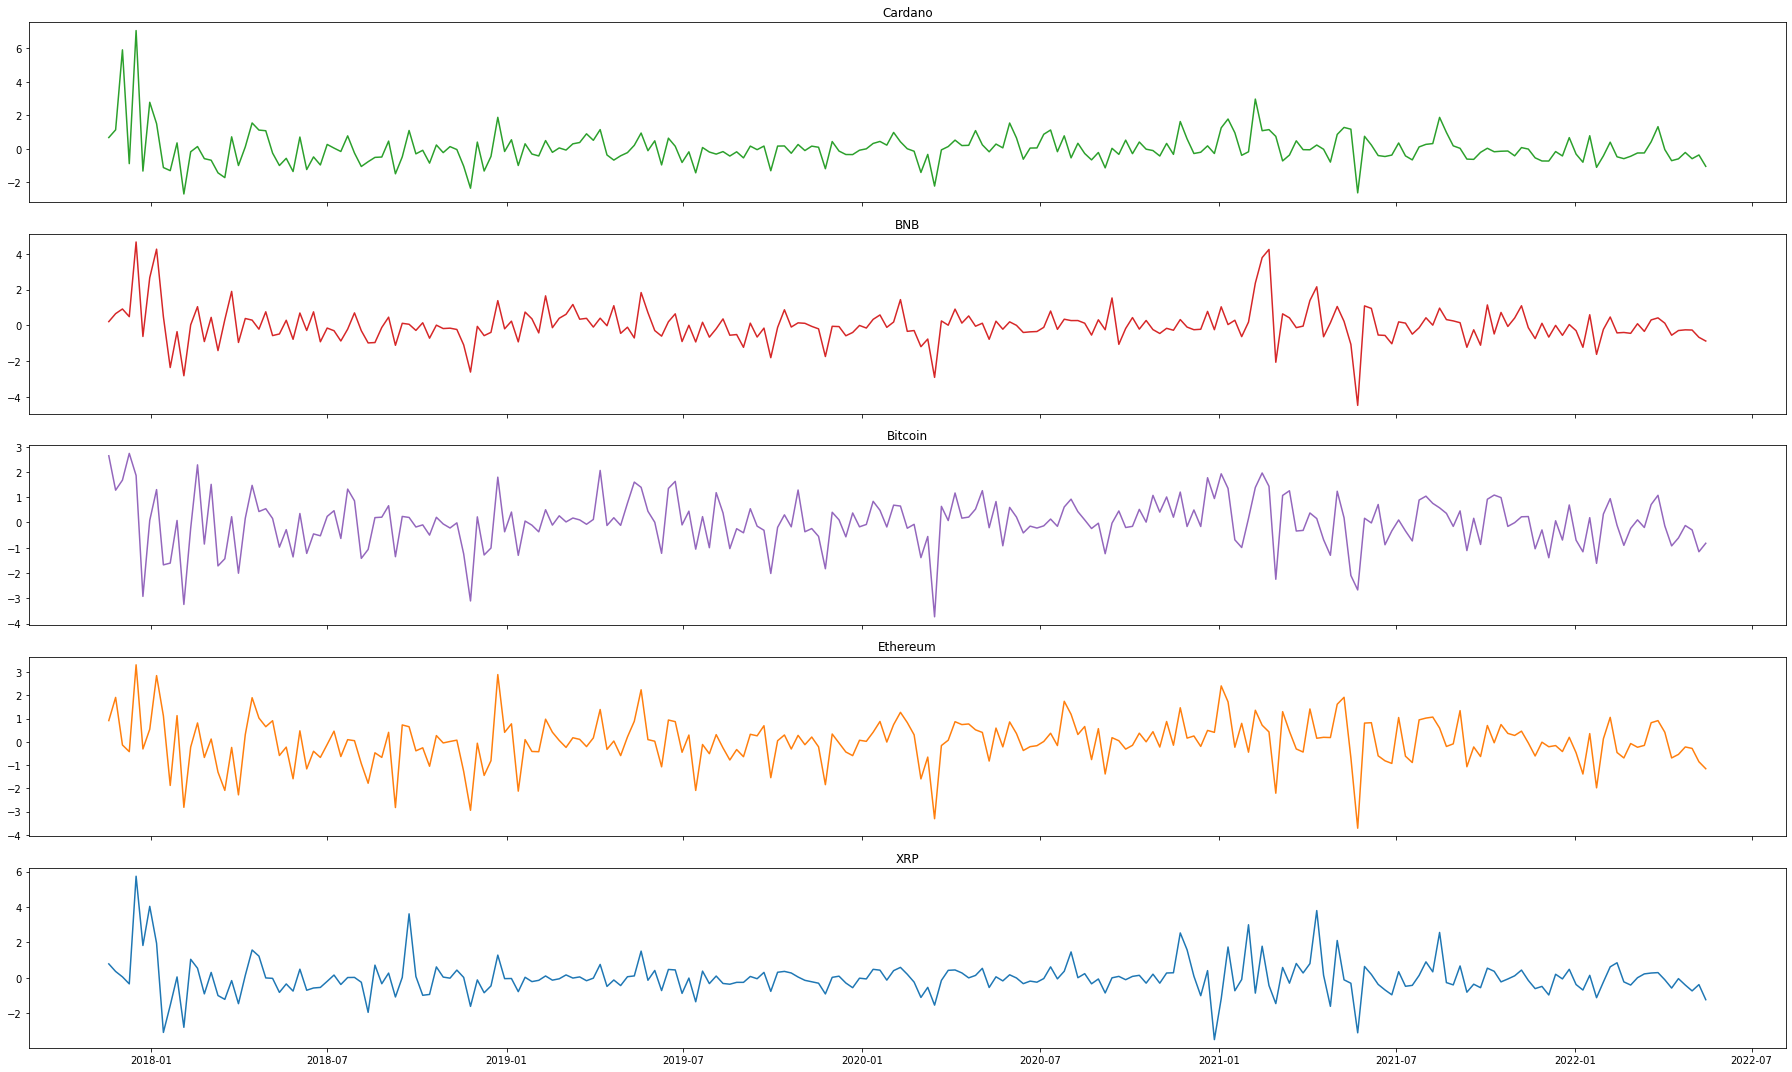

In [9]:
# Plotting the standarized data for cryptocurrencies
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(25, 15), sharex = True)

ax1.plot(data.index, data['std_ADA'].values, 'tab:green')
ax1.set_title('Cardano')
ax2.plot(data.index, data['std_BNB'].values, 'tab:red')
ax2.set_title('BNB')
ax3.plot(data.index, data['std_BTC'].values, 'tab:purple')
ax3.set_title('Bitcoin')
ax4.plot(data.index, data['std_ETH'].values, 'tab:orange')
ax4.set_title('Ethereum')
ax5.plot(data.index, data['std_XRP'].values, 'tab:blue')
ax5.set_title('XRP')

fig.tight_layout()

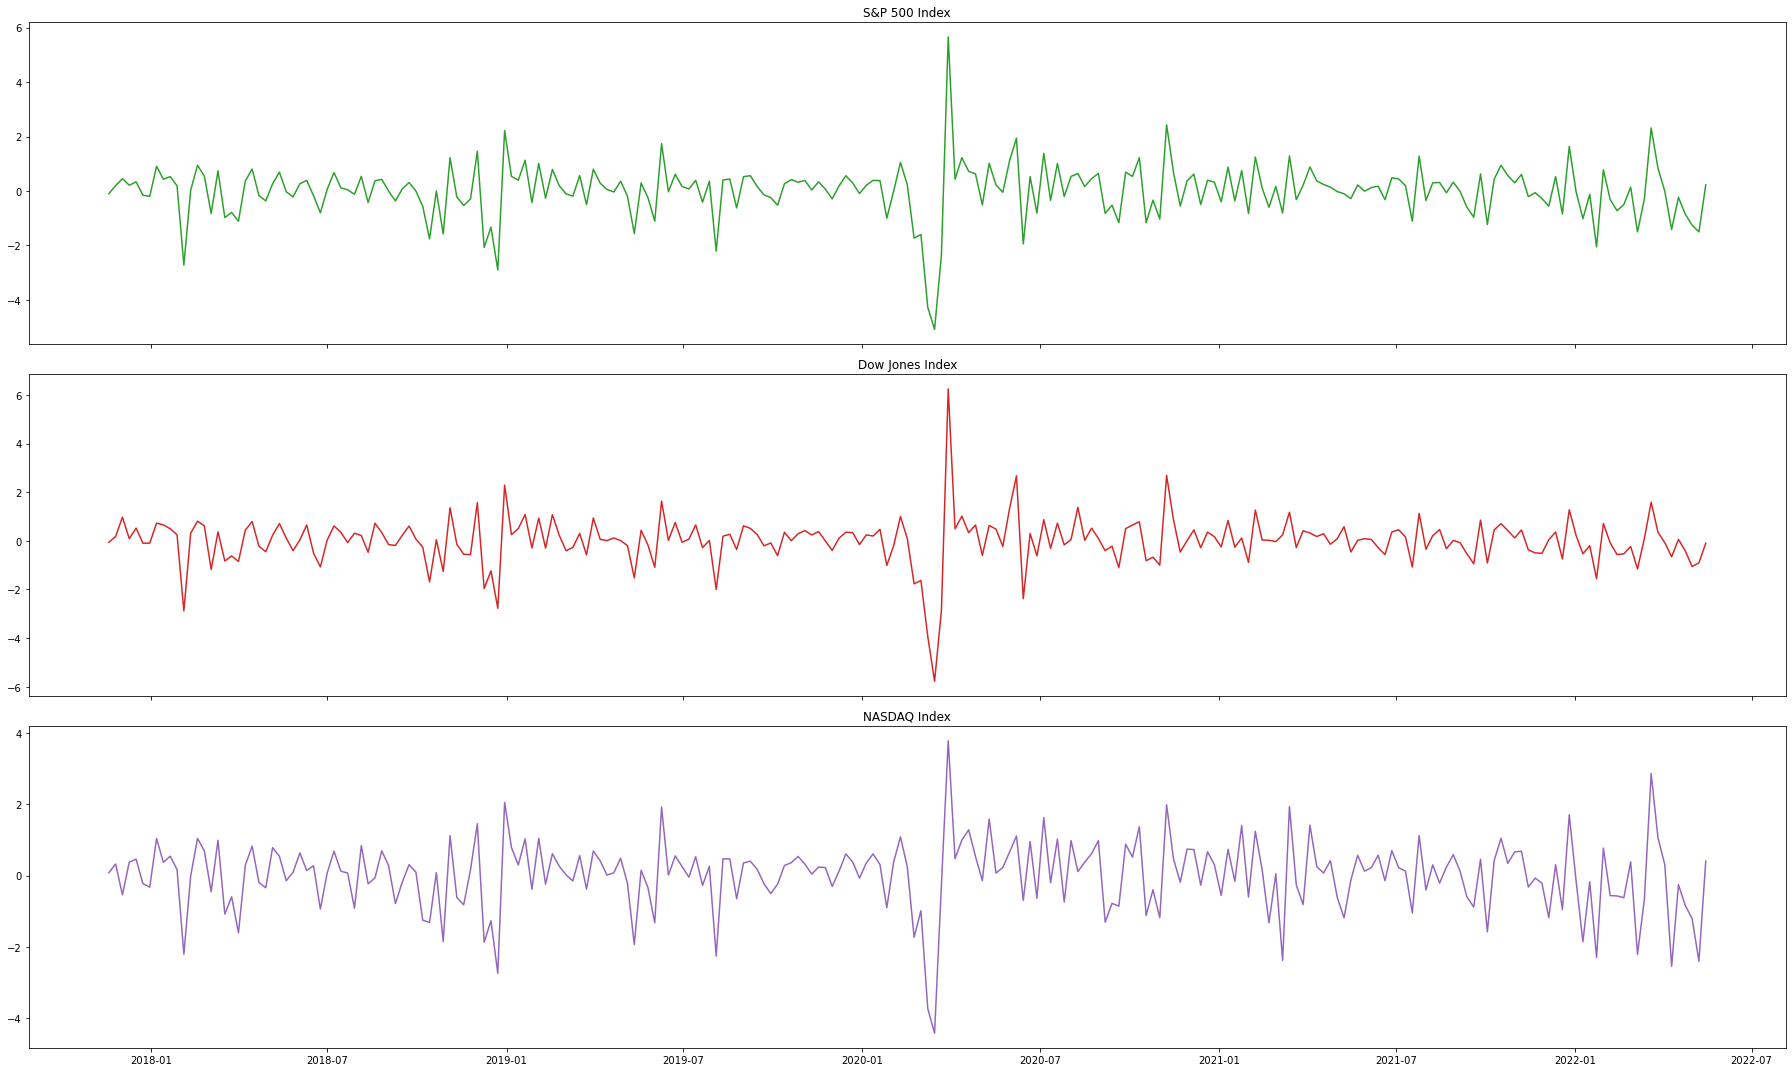

In [10]:
# Plotting the standarized data for stock marker indexes
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(25, 15), sharex = True)

ax1.plot(data.index, data['std_SPX'].values, 'tab:green')
ax1.set_title('S&P 500 Index')
ax2.plot(data.index, data['std_DOWJ'].values, 'tab:red')
ax2.set_title('Dow Jones Index')
ax3.plot(data.index, data['std_NASD'].values, 'tab:purple')
ax3.set_title('NASDAQ Index')

fig.tight_layout()

***Section 2: Dynamic Factors Models and application***

In this section, we will estimate a dynamic factor model for the cryptocurrencies considered.

As seen in class, a general dynamic factor model is written as:

$$
\begin{align}
y_t & = \beta f_t + B x_t + u_t \\
f_t & = \lambda_1 f_{t-1} + \dots + \lambda_p f_{t-p} + \eta_t \qquad \eta_t \sim N(0, I)\\
u_t & = \theta_1 u_{t-1} + \dots + \theta_q u_{t-q} + \varepsilon_t \qquad \varepsilon_t \sim N(0, \Sigma)
\end{align}
$$

where $y_t$ are observed data, $f_t$ are the unobserved factors (evolving as a vector autoregression), $x_t$ are (optional) exogenous variables, and $u_t$ is the error, or "idiosyncratic", process ($u_t$ is also optionally allowed to be autocorrelated). The $\beta$ matrix is often referred to as the matrix of "factor loadings". The variance of the factor error term is set to the identity matrix to ensure identification of the unobserved factors.

This model can be cast into state space form, and the unobserved factor estimated via the Kalman filter. The likelihood can be evaluated as a byproduct of the filtering recursions, and maximum likelihood estimation used to estimate the parameters.

**Model Specification for cryptocurrencies**

For the model specification, we will take into account the work carried out by Figá-Talamanca et al (2021) but with some particular considerations. Specifically, the authors do not demean the prices and run the dynamic factor model with price levels. Given their complementary cointegration analysis, they expect to find a value of $\lambda_1$ close to one amid their analysis of non-stationary price levels. In this work, I have demeaned the prices and, as such, I expect no particular value for lamba 1. Hence, the model specification for cryptocurrencies is as follows:

$$
\begin{align}
y_{i,t} & = \beta_{i,1} f_{1,t} + \beta_{i,2} f_{2,t} + u_{i,t} \\
f_{1,t} & = \lambda_1 f_{1, t-1} + \eta_{1,t} \\
f_{2,t} & = \lambda_2 f_{2, t-1} + \eta_{2,t} \\
u_{i,t} & = \theta_{1,i} u_{i,t-1} + \theta_{2,i} u_{i,t-2} + \dots + \theta_{p,i} u_{i,t-p} + \varepsilon_{i,t} 
\end{align}
$$

For our purposes, $i$ is one of `[ADA, BNB, BTC, ETH, XRP]` and the optimal lags of the idiosincratic error $u_{i,t}$ will be determined by minimizing information criteria.

We will use the `DynamicFactor` model built-in to statsmodels. The specification is as follows:

- `k_factors = 2` - (there are 2 unobserved factor)
- `factor_order = 1` - (they follow an AR(1) process)
- `error_var = False` - (the errors evolve as independent AR processes rather than jointly as a VAR - note that this is the default option, so it is not specified below)
- `error_order = q` - (the errors are autocorrelated of order q: i.e. AR(q) processes - will be determined by looking at information criteria)
- `error_cov_type = 'diagonal'` - (the innovations are uncorrelated; this is again the default)

Once the model is created, the parameters can be estimated via maximum likelihood; this is done using the `fit()` method.

In [11]:
%%time
# Estimating the model

# Endogenous variables
crypto_endog = data.loc[:, 'std_ADA':'std_XRP']

# Setting up the model
mod1 = sm.tsa.DynamicFactor(crypto_endog, k_factors = 2, factor_order = 1, error_order = 1)

# Estimate the model. We follow the approach seen in class: find an initial set of parameters, and then apply LBFGS.
crypto_initial = mod1.fit(method = 'powell')
crypto_results = mod1.fit(crypto_initial.params)

# Storing the factors for later
crypro_f1 = crypto_results.factors.filtered[0]
crypro_f2 = crypto_results.factors.filtered[1]

Optimization terminated successfully.
         Current function value: 5.434447
         Iterations: 11
         Function evaluations: 3080
Wall time: 3.73 s


In [12]:
crypto_results.summary(separate_params = True)

#Manual recording of BIC for several lenths of q
# q = 1, BIC = 2685.101
# q = 2, BIC = 2692.494
# q = 3, BIC = 2714.044 (convernce warning)
# q = 4, BIC = 2724.748
# We select q = 1 as the lag length for the error term.

Dep. Variable:,"['std_ADA', 'std_BNB', 'std_BTC', 'std_ETH', 'std_XRP']",No. Observations:,235
Model:,"DynamicFactor(factors=2, order=1)",Log Likelihood,-1277.035
,+ AR(1) errors,AIC,2602.071
Date:,"Tue, 24 May 2022",BIC,2685.101
Time:,12:33:14,HQIC,2635.544
Sample:,11-19-2017,,
,- 05-15-2022,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.83, 0.03, 0.01, 0.26, 0.00",Jarque-Bera (JB):,"1001.12, 214.35, 39.54, 105.94, 757.58"
Prob(Q):,"0.36, 0.86, 0.90, 0.61, 0.94",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.40, 1.39, 0.61, 0.61, 1.37",Skew:,"1.62, -0.02, 0.23, -0.09, 0.63"


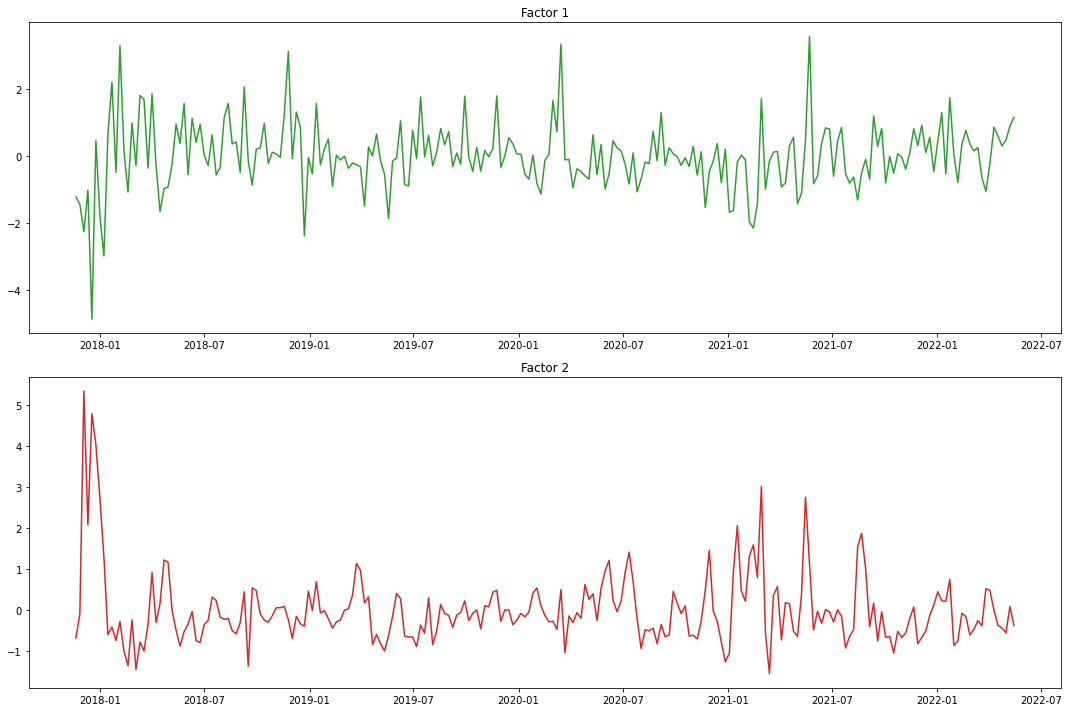

In [13]:
# I plot the evolution of both factores estimated
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))

# Plot the factor
dates = crypto_endog.index._mpl_repr()
ax1.plot(dates, crypto_results.factors.filtered[0], 'tab:green', label = 'Factor 1')
ax1.set_title('Factor 1')
ax2.plot(dates, crypto_results.factors.filtered[1], 'tab:red', label = 'Factor 2')
ax2.set_title('Factor 2')

fig.tight_layout()

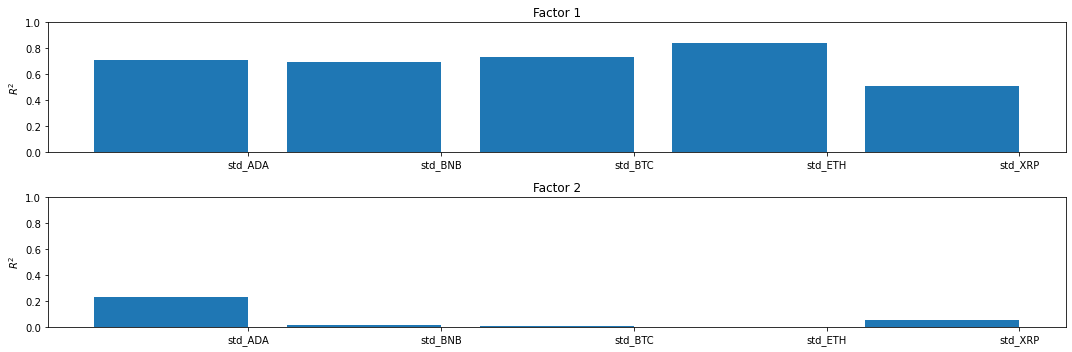

In [14]:
# I also observe the coefficients of determination, and find that ETH is the factor that contributes the most to the first factor.
# In contraste, only ADA and to a lesser extent XRP explain the behavior of the second factor.
crypto_results.plot_coefficients_of_determination(figsize=(15,5)).tight_layout();

In [15]:
# A minor output to check how strong the relationship the estimated factors would be.
# If the correlations were 1 or -1, a potential common trend might be present in the factors.
np.corrcoef(crypto_results.factors.filtered[0], crypto_results.factors.filtered[1])

array([[ 1.        , -0.20984631],
       [-0.20984631,  1.        ]])

**Model Specification for stock market indexes**

For the model specification for stock market indexes, there exists a vast amount of literature regarding application of dynamic factor models to asset prices. Perhaps one of the most known is Ng, Victor, Engle, Robert F., Rothschild, Michael (1992) "A multi-dynamic-factor model for stock returns". In here, a more practical approach will be taken. Specifically, I will estimate the model with 1 factor which follows an AR(1) process and evaluate different values of q. It is no news that stock market indexes are notably correlated with each other given the fact that, as indexes with several amount of stocks, more often than not we observe movements related to systematic (and therefore common) risk.

$$
\begin{align}
y_{i,t} & = \beta_{i,1} f_{1,t} + u_{i,t} \\
f_{1,t} & = \lambda_1 f_{1, t-1} + \eta_{1,t} \\
u_{i,t} & = \theta_{1,i} u_{i,t-1} + \theta_{2,i} u_{i,t-2} + \dots + \theta_{p,i} u_{i,t-p} + \varepsilon_{i,t} 
\end{align}
$$

In this case, $i$ is one of `[SPX, DOWJ, NASD]` and the optimal lags of the idiosincratic error $u_{i,t}$ will be determined by minimizing information criteria.

In [16]:
%%time
# Estimating the model

# Endogenous variables
smi_endog = data.loc[:, 'std_SPX':'std_NASD']

# Setting up the model
mod2 = sm.tsa.DynamicFactor(smi_endog, k_factors = 1, factor_order = 1, error_order = 1)

# Estimate the model. We follow the approach seen in class: find an initial set of parameters, and then apply LBFGS.
smi_initial = mod2.fit(method = 'powell')
smi_results = mod2.fit(smi_initial.params)

# Storing the factors for later
smi_f1 = smi_results.factors.filtered[0]

# Note, if k_factors is set to 2, convergence warning emerges.

Optimization terminated successfully.
         Current function value: 1.924422
         Iterations: 6
         Function evaluations: 771
Wall time: 813 ms


In [17]:
smi_results.summary(separate_params = True)

#Manual recording of BIC for several lenths of q
# q = 1, BIC = 959.074
# q = 2, BIC = 973.653
# q = 3, BIC = 989.394
# q = 4, BIC = 1006.566
# We select q = 1 as the lag length for the error term.

Dep. Variable:,"['std_SPX', 'std_DOWJ', 'std_NASD']",No. Observations:,235
Model:,"DynamicFactor(factors=1, order=1)",Log Likelihood,-452.239
,+ AR(1) errors,AIC,924.479
Date:,"Tue, 24 May 2022",BIC,959.074
Time:,12:33:16,HQIC,938.426
Sample:,11-19-2017,,
,- 05-15-2022,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.01, 0.02",Jarque-Bera (JB):,"567.03, 25.09, 289.20"
Prob(Q):,"0.99, 0.92, 0.89",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.80, 2.56, 2.71",Skew:,"-0.14, 0.36, -0.44"


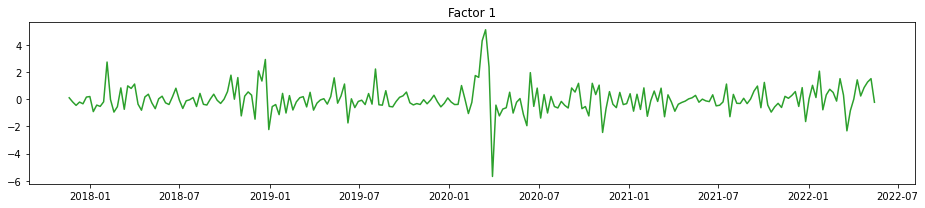

In [18]:
# I plot the evolution of the estimated factor
fig, (ax1) = plt.subplots(1, figsize=(13,3))

# Plot the factor
dates = smi_endog.index._mpl_repr()
ax1.plot(dates, smi_results.factors.filtered[0], 'tab:green', label = 'Factor 1')
ax1.set_title('Factor 1')

fig.tight_layout()

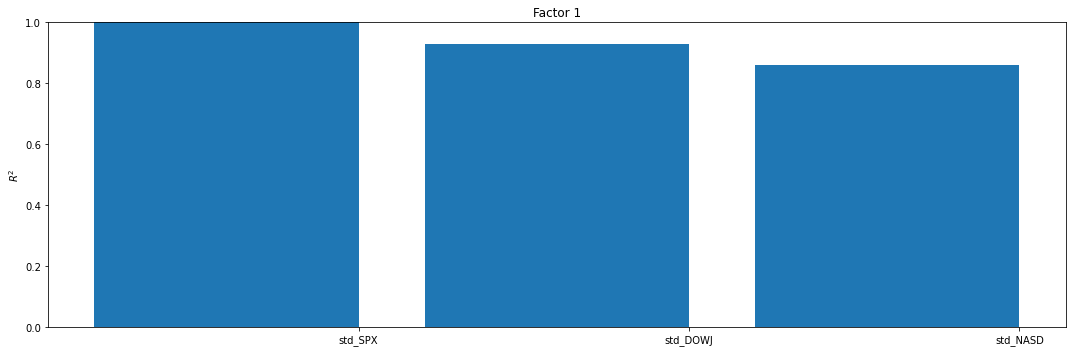

In [19]:
# To an extent almost unsurprisingly, the SPX explains most of the common factor across these stock indexes.
smi_results.plot_coefficients_of_determination(figsize=(15,5)).tight_layout();

**Application of dynamic factors obtained**

With the estimated factors obtained both for cryptocurrencies and stock market indexes, some further exploration can be made regarding the relationship between these asset classes. As a first approach, I will make a standard linear regressions under the following logic:

$$
\begin{align}
f_{1, crypto, t} & = \alpha_1 + \gamma_1 f_{stock, t} + \mu_{1,t} \\
f_{2, crypto, t} & = \alpha_2 + \gamma_2 f_{stock, t} + \mu_{2,t} \\
\end{align}
$$

Some comment on the above regressions. First, even if these are only exploratory regressions, the underlying logic when being presented is that of a Capital Asset Pricing Model. That is, it is an exploration of how related are the underlying factors between the asset classes, if at all. More precisely, the logic is that these regressions could, potentially, be extended to include other factors in a Fama-French or Carhart fashion. In this simple version, the interest is set on the values of $\gamma_1$ and $\gamma_2$. This is a modest attempt to answer the more practical question: are the movements in cryptocurrencies and stock market indexes related? A first hypothesis would be that both gamma $\gamma$ estimates would be equal to 0.

Another comment ot make is that this practical approach can have further extensions. For instance, if we had estimated a dynamic factor model for more traditional asset classes (i.e. stock market, bond market, currencies, commodities, etc), the above regressions could easily be adapted to have further exploration on the drivers of common movements in cryptocurrencies.

In [20]:
smi_f1 = sm.add_constant(smi_f1)

crypto_model_1 = sm.OLS(crypro_f1, smi_f1)
crypto_model_2 = sm.OLS(crypro_f2, smi_f1)

output1 = crypto_model_1.fit()
output2 = crypto_model_2.fit()

print(output1.summary())
print(output2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     17.44
Date:                Tue, 24 May 2022   Prob (F-statistic):           4.19e-05
Time:                        12:33:16   Log-Likelihood:                -325.45
No. Observations:                 235   AIC:                             654.9
Df Residuals:                     233   BIC:                             661.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.063     -0.003      0.9

As we can observe from the first regression, surprisingly the value of the stock market index coefficient is positive and significant. In addition, a Durbin-Watson close to 2 is reported, consistent with a very low first-order autocorrelation of the error term. However, it should be noted that the R2 metrics for the first regression are notably low. In the case of the second regression, I find no significant relationship between the second crypto factor and the stock market factor.

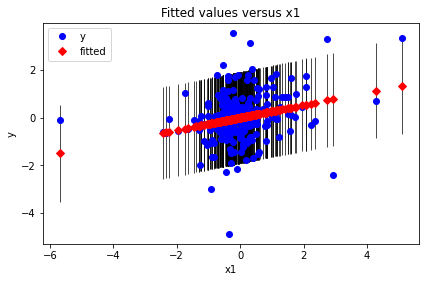

In [21]:
# A simple plot between the values of the stock market factor and the first dynamic crypto factor.
fig = sm.graphics.plot_fit(output1, 'x1')
fig.tight_layout(pad=1.0)

**Section 3: Conclusions and further work**

One first conclusion is that, given the selected set of cryptocurrencies, I was able to estimate a relatively compact 2 dynamic factor model. Pushing the limits of interpretation, the first factor did seem to be a pretty good indicator of a common component across the cryptocurrency pairs and, to that extent, capture the movements of the cryptocurrency returns. The second factor, although less prominent in its relationship with the cryptocurrencies, did relate to a lesser extent with the ADA and XRP pairs.

On a similar note, a compact dynamic factor was estimated for the stock market indexes. Importantly, this factor was very intensely correlated with the SPX index returns, although it could be argues that such result was expected.

Based on the factors obtained, I proposed a very simple and practical approach to explore the relationship between the dynamic factors of these asset classes. Granted its simplicity and limitations, the approach enables the exploration of how the asset classes relate, and it can be easily extended for further analysis. Surprisingly, this very preliminar approach reveals that there is a modest relationship between the most prominent dynamic factor of cryptocurrencies and the stock market dynamic factor. These result only contributes to a recurring ongoing discussion about cryptocurrencies as a financial investment.

Some comments are to be made regarding the work carried out here:
- In this project, the returns of all of the assets were used as inputs for the dynamic model estimation. There should be no reason for which the input could be the direct price levels, other than additional work in finding out an approapiate state-space representation for both asset classes (this could be, in fact, a decent amount of work given the non-stationary nature of price levels in time series).
- The decision to include the specific set of cryptocurrencies `[ADA, BNB, BTC, ETH, XRP]` and stock market indexes `[SPX, DOWJ, NASDAQ]` was, to an extent, arbitrary. In the case of cryptocurrencies, the idea of selecting the biggest and with most data available assets was to try and capture the common movements across these assets. The objective is not to predict specific price movements of these assets in order to capture any potential "alpha", but rather to make an inference of the drivers of these movements at a general level. Similarly, the stock market indexes selected were a result of a simplicity criteria: those indexes are the most commonly followed stock market indexes when looking at financial data. Aside from the above mentioned, there should be no particular reason why further assets or indexes could be included in each category.

There is definitely further work that could be carried out in this line of exploration:
- A very interesting approach that was not attempted was the implementation of hidden state models to the estimated factors. The idea would be to estimate a hidden factor model which enables us to infer about bear and bull markets, and estimate this hidden state model to the factors estimated. It would be very interesting to see if the bear and bull periods in these estimated dynamic factors match at all. Notably, it should be noted that this is an extra layer of application to state-space models (a state model on state model outputs), and interpretation should be carried out with care.
- In this particular project, I did not construct a coincident index as we saw in class. It should be totally possible to construct such an index with the mentioned factors and use that as the variable to analyse further. The only "excuse" to not apply this method in this project is that, conceptually, everything is expressed in terms of the dynamic factors related to returns, and the coincident index implies another transformation to the outputs.
- In case the very simple regression approach proposed here was to be considered, the idea of factor models (i.e. Fama-French, Carhart, etc.), would be possible and, therefore another branch of analysis could arrise. Fama-French factors are available and could be used as additional exogenous factors in these regressions. Would it be possible for any of these factors to explain any movement in the dynamic factors of cryptocurrencies?
- Following up on the previous point, a linear regression is a very simple statistical approach to perform the mentioned analysis. Clearly, there is a vast number of possible approaches to carry out the analysis.

**Bibliography and relevant links**

Figá-Talamanca et al (2021) - https://link.springer.com/article/10.1007/s10203-021-00318-x

Victor Ng, Robert F. Engle, Michael Rothschild (1992) - https://www.sciencedirect.com/science/article/pii/030440769290072Y

Statsmodels.org - https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor.DynamicFactor.html#statsmodels.tsa.statespace.dynamic_factor.DynamicFactor